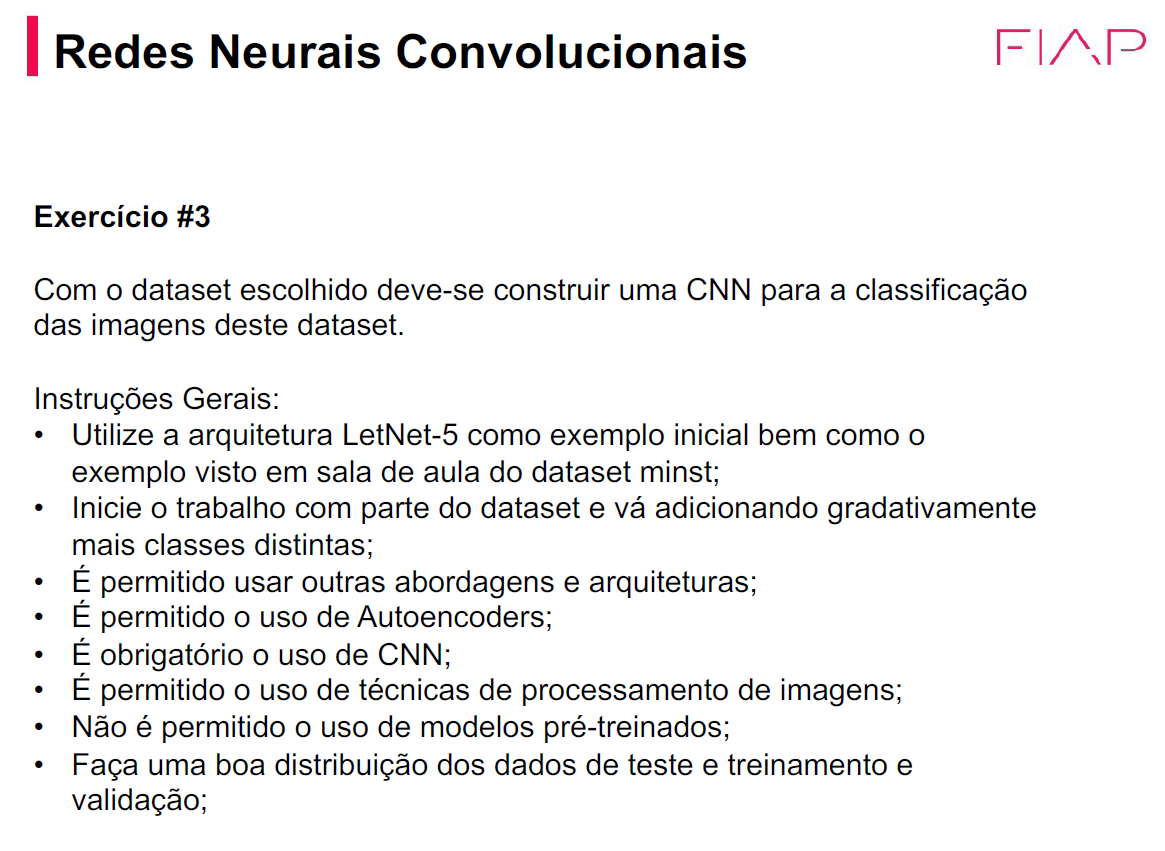

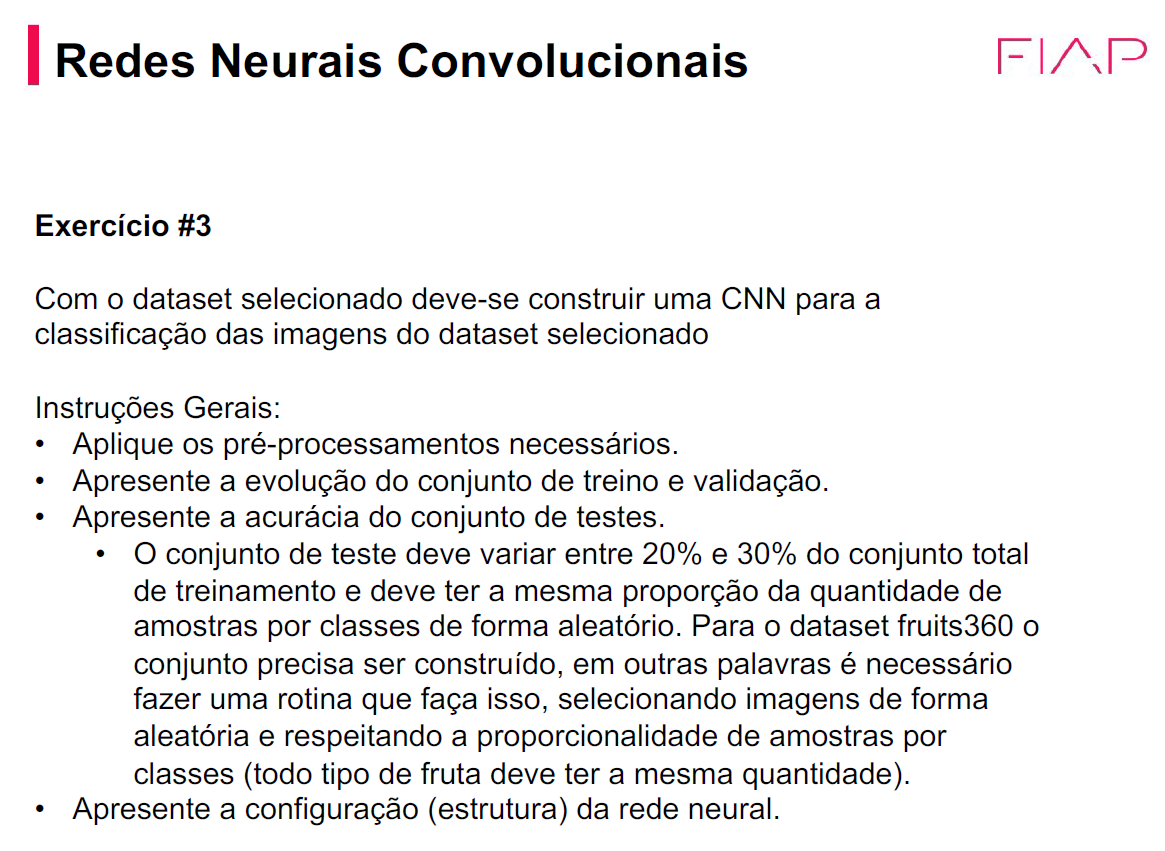

# Dataset Escolhido - CoronaHack-Chest X-Ray-Dataset

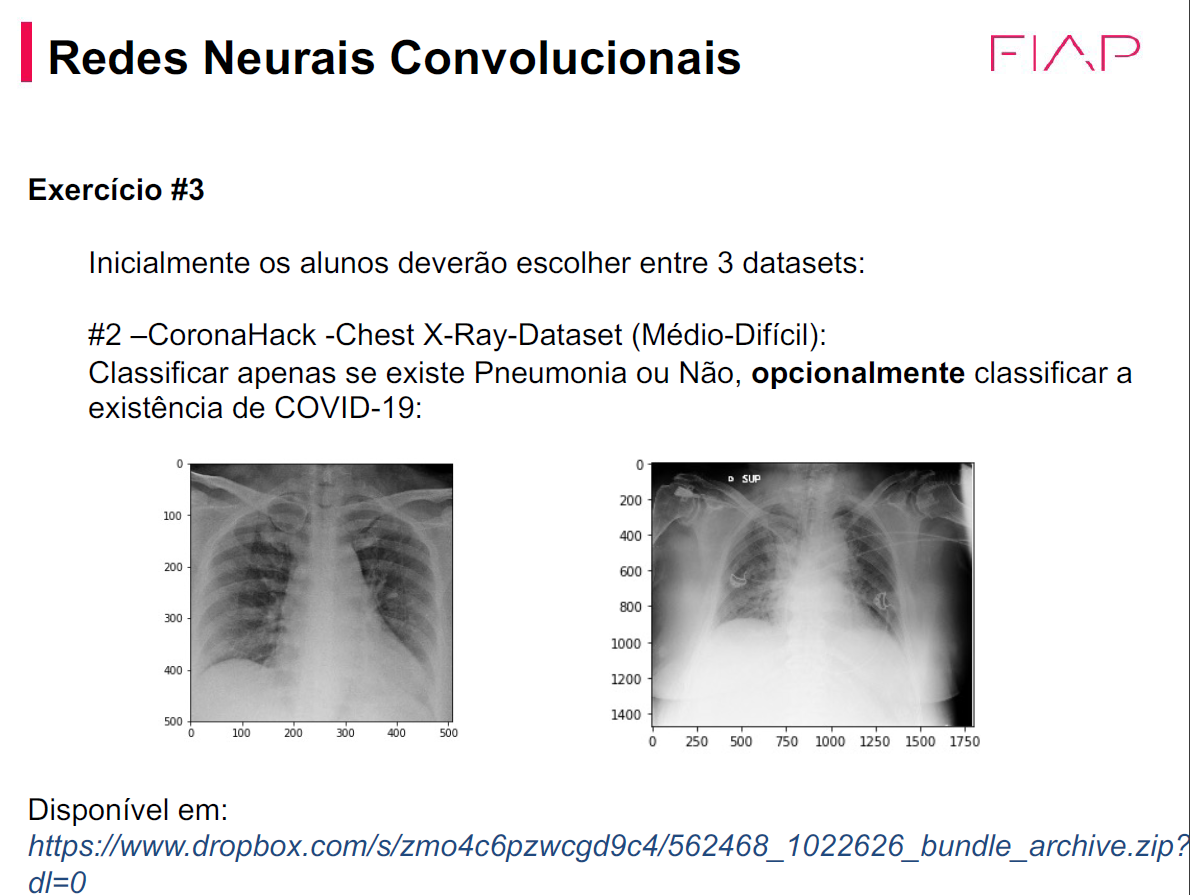

### _Consideramos as imagens do dataset dentro no sub-diretório ```images``` de onde está o arquivo deste notebook_

### Trabalho desenvolvido durante o MBA em Data Science / IA na FIAP - 2022~2023.

### Prof. Felipe Teodoro

## Imports das Bibliotecas

In [1]:
import pandas as pd
import os
import shutil
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img

from scipy.signal import convolve2d

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.utils import plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

## Configurações

In [2]:
RANDOM_STATE = 73
DIM_IMAGEM = (320, 320)

np.random.seed(RANDOM_STATE)

## Carga dos Metadados

In [3]:
metadados = pd.read_csv('./Chest_xray_Corona_Metadata.csv', index_col = 0)

## Visualização do Dataset

In [4]:
display(metadados.head(5))
display(metadados.tail(5))

X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

X_ray_image_name     Label Dataset_type  \
5928  person1637_virus_2834.jpeg  Pnemonia         TEST   
5929  person1635_virus_2831.jpeg  Pnemonia         TEST   
5930  person1634_virus_2830.jpeg  Pnemonia         TEST   
5931  person1633_virus_2829.jpeg  Pnemonia         TEST   
5932  person1632_virus_2827.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
5928                    NaN                  Virus  
5929                    NaN                  Virus  
5930                    NaN                  Virus  
5931                    NaN                  Virus  
5932                    NaN                  Virus

## Verificação do Dataset

Informações, ausências e duplicatas

In [5]:
metadados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 0 to 5932
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   X_ray_image_name        5910 non-null   object
 1   Label                   5910 non-null   object
 2   Dataset_type            5910 non-null   object
 3   Label_2_Virus_category  69 non-null     object
 4   Label_1_Virus_category  4334 non-null   object
dtypes: object(5)
memory usage: 277.0+ KB


In [6]:
metadados.isnull().sum()

X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [7]:
metadados.duplicated().sum()

0

In [8]:
metadados['X_ray_image_name'].duplicated().sum()

0

Nenhuma ausência de valores nas informações das imagens e dos rótulos. Há ausências significativas nas colunas de categoria de vírus, principalmente categoria 2.

### Contagem de Classes para a coluna `Label` (Pneumonia ou não)

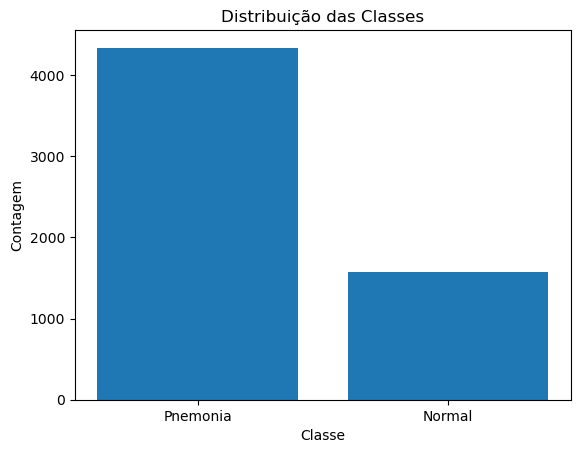

In [9]:
class_counts = metadados['Label'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

### Contagem de Classes para a coluna `Label_1_Virus_category` (Origem da Pneumonia: virus, bacteria, fumo ou desconhecido)

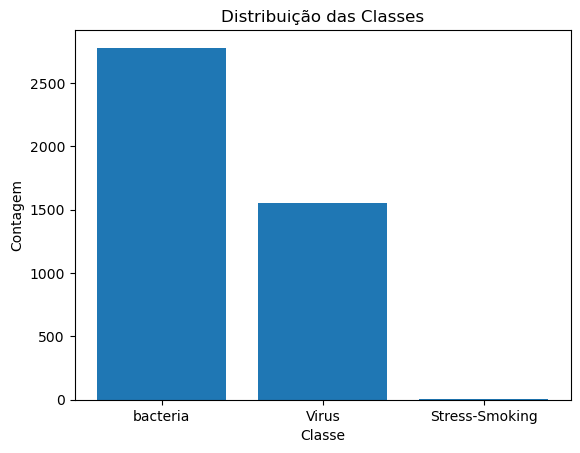

In [10]:
class_counts = metadados['Label_1_Virus_category'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

### Contagem de Classes para a coluna `Label_2_Virus_category` (Origem da Pneumonia: COVID-19, Streptococcus, SARS ou ARDS)

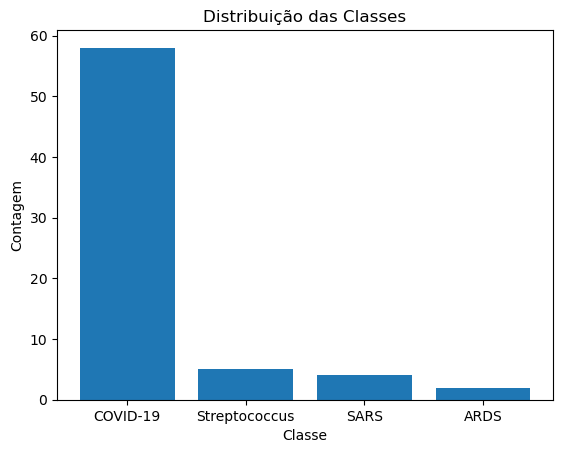

In [11]:
class_counts = metadados['Label_2_Virus_category'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Distribuição das Classes')
plt.show()

### Investigação das Colunas Label_1_Virus_category e Label_2_Virus_category

In [12]:
metadados['Label_1_Virus_category'].value_counts()

bacteria          2777
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64

In [13]:
metadados['Label_1_Virus_category'].isnull().sum()

1576

In [14]:
metadados['Label_2_Virus_category'].value_counts()

COVID-19         58
Streptococcus     5
SARS              4
ARDS              2
Name: Label_2_Virus_category, dtype: int64

In [15]:
metadados['Label_1_Virus_category'].isnull().sum()

1576

In [16]:
metadados[metadados['Label_1_Virus_category'] == 'Virus']['Dataset_type'].value_counts()

TRAIN    1407
TEST      148
Name: Dataset_type, dtype: int64

In [17]:
metadados['Label_2_Virus_category'].isnull().sum()

5841

A quantidade de dados disponível nas colunas `Label_1_Virus_category` e `Label_2_Virus_category` é pequena, e consideramos essas informações como não tão relevantes para o escopo deste estudo. Portanto, nossa abordagem se limitará à utilização das imagens e do rótulo alvo, que indica a presença ou ausência de pneumonia, para a condução deste trabalho.

## Análise Exploratória Visual das Imagens

Ao fazermos uma análise exploratória das imagens, detectamos imagens provenientes de outro tipo de exame que parecem se tratar de Ressonância Magnética (RM) ou Tomografia Computadorizada (TC). Um profissional da área médica poderia confirmar esta informação, mas claramente não se tratam de Raio X. Podemos conferir isto abaixo.

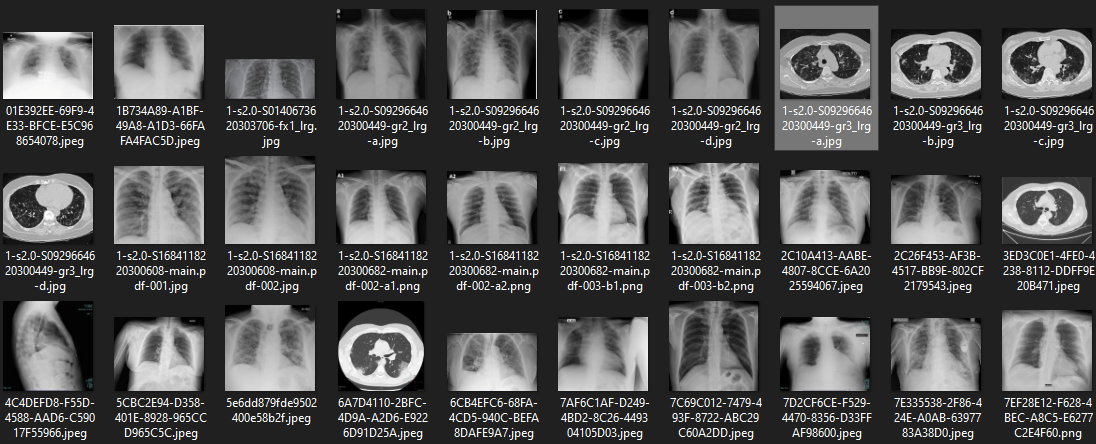

São elas:

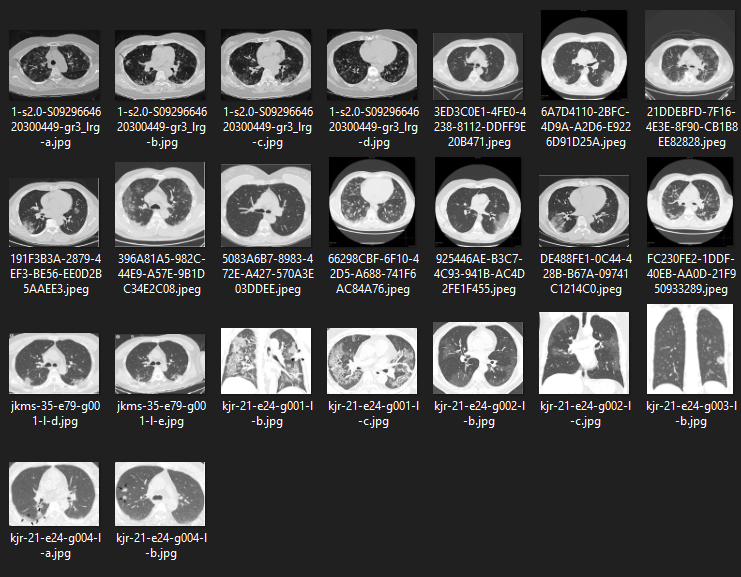

Uma separação destas imagens diferentes foi feita no sistema de arquivos e seus nomes levantados para verificar se fazem parte do dataset, pois caso façam, serão descartadas para não se inserir ruído no treinamento.

In [18]:
nrx = ['1-s2.0-S0929664620300449-gr3_lrg-a.jpg', '1-s2.0-S0929664620300449-gr3_lrg-b.jpg', 
       '1-s2.0-S0929664620300449-gr3_lrg-c.jpg', '1-s2.0-S0929664620300449-gr3_lrg-d.jpg',
       '191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg', '21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg',
       '396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg', '3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg',
       '5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg', '66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg',
       '6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg', '925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg',
       'DE488FE1-0C44-428B-B67A-09741C1214C0.jpeg', 'FC230FE2-1DDF-40EB-AA0D-21F950933289.jpeg',
       'jkms-35-e79-g001-l-d.jpg', 'jkms-35-e79-g001-l-e.jpg', 'kjr-21-e24-g001-l-b.jpg',
       'kjr-21-e24-g001-l-c.jpg', 'kjr-21-e24-g002-l-b.jpg', 'kjr-21-e24-g002-l-c.jpg',
       'kjr-21-e24-g003-l-b.jpg', 'kjr-21-e24-g004-l-a.jpg', 'kjr-21-e24-g004-l-b.jpg']

metadados['RaioX'] = metadados['X_ray_image_name'].apply(lambda a: 'Não' if a in nrx else 'Sim')

In [19]:
metadados['RaioX'].value_counts()

Sim    5910
Name: RaioX, dtype: int64

In [20]:
metadados.drop('RaioX', axis = 1, inplace = True)
metadados

X_ray_image_name     Label Dataset_type  \
0              IM-0128-0001.jpeg    Normal        TRAIN   
1              IM-0127-0001.jpeg    Normal        TRAIN   
2              IM-0125-0001.jpeg    Normal        TRAIN   
3              IM-0122-0001.jpeg    Normal        TRAIN   
4              IM-0119-0001.jpeg    Normal        TRAIN   
...                          ...       ...          ...   
5928  person1637_virus_2834.jpeg  Pnemonia         TEST   
5929  person1635_virus_2831.jpeg  Pnemonia         TEST   
5930  person1634_virus_2830.jpeg  Pnemonia         TEST   
5931  person1633_virus_2829.jpeg  Pnemonia         TEST   
5932  person1632_virus_2827.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
0                       NaN                    NaN  
1                       NaN                    NaN  
2                       NaN                    NaN  
3                       NaN                    NaN  
4                       NaN                    NaN  
...                     ...                    ...  
5928                    NaN                  Virus  
5929                    NaN                  Virus  
5930                    NaN                  Virus  
5931                    NaN                  Virus  
5932                    NaN                  Virus  

[5910 rows x 5 columns]

Vimos portanto que o dataset já desconsidera essas imagens, então não precisamos nos preocupar com elas.

## Verificação da separação de Treino e Teste

O dataset já feio com separação de treino e teste. Vamos verificar a proporção.

In [21]:
metadados['Dataset_type'].value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [22]:
metadados['Dataset_type'].value_counts(normalize = True)

TRAIN    0.894416
TEST     0.105584
Name: Dataset_type, dtype: float64

Temos aproximadamente 90% para Treino e 10% para teste. Não é a proporção adequada para treinamento e teste do modelo pretendido. Vamos reorganizar para termos 70% de treino e 30% de teste.

In [23]:
qtd_train = (metadados['Dataset_type'] == 'TRAIN').sum()
qtd_test = (metadados['Dataset_type'] == 'TEST').sum()

falta_test = qtd_train - int(0.7 * (qtd_train + qtd_test))

In [24]:
metadados = metadados.sample(frac = 1, random_state = RANDOM_STATE)

In [25]:
idx_train2test = metadados[metadados['Dataset_type'] == 'TRAIN'].sample(n = falta_test, random_state  = RANDOM_STATE).index

In [26]:
pd.DataFrame(metadados.loc[metadados.index.isin(idx_train2test)])['Dataset_type'].value_counts()

TRAIN    1149
Name: Dataset_type, dtype: int64

In [27]:
metadados.loc[idx_train2test, 'Dataset_type'] = 'TEST'

In [28]:
metadados.reset_index(drop = True, inplace = True)

In [29]:
metadados['Dataset_type'].value_counts()

TRAIN    4137
TEST     1773
Name: Dataset_type, dtype: int64

In [30]:
metadados['Dataset_type'].value_counts(normalize = True)

TRAIN    0.7
TEST     0.3
Name: Dataset_type, dtype: float64

Agora temos uma proporção apropriada de treinamento e teste para o dataset. A separação de validação será feita diretamente na chamada do método de treinamento da CNN, mais a frente.

## Preparação dos Dados

In [31]:
metadados_pneumonia = metadados[['X_ray_image_name', 'Label', 'Dataset_type']].copy()

In [32]:
metadados_pneumonia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   X_ray_image_name  5910 non-null   object
 1   Label             5910 non-null   object
 2   Dataset_type      5910 non-null   object
dtypes: object(3)
memory usage: 138.6+ KB


In [33]:
metadados_pneumonia.duplicated().sum()

0

In [34]:
metadados_pneumonia.isnull().sum()

X_ray_image_name    0
Label               0
Dataset_type        0
dtype: int64

In [35]:
metadados_pneumonia['Label'].unique()

array(['Pnemonia', 'Normal'], dtype=object)

Vamos melhorar os rótulos para legibilidade do trabalho.

In [36]:
metadados_pneumonia['Label'] = metadados_pneumonia['Label'].apply(lambda x: 'negativo' if x == 'Normal' else 'positivo')

In [37]:
metadados_pneumonia['Label'].value_counts(normalize = True) * 100

positivo    73.333333
negativo    26.666667
Name: Label, dtype: float64

Introduzimos uma variável alvo com o propósito de simplificar a entrada de dados na rede neural, atribuindo o valor `0` para casos **negativos** (indicando a **ausência** de pneumonia) e o valor `1` para casos **positivos** (indicando a **presença** de pneumonia).

In [38]:
metadados_pneumonia['target'] = metadados_pneumonia['Label'].apply(lambda x: 0 if x == 'negativo' else 1)

In [39]:
metadados_pneumonia['target'].value_counts()

1    4334
0    1576
Name: target, dtype: int64

In [40]:
metadados_pneumonia['target'].value_counts(normalize = True) * 100

1    73.333333
0    26.666667
Name: target, dtype: float64

In [41]:
metadados_pneumonia['Dataset_type'].value_counts(normalize = True) * 100

TRAIN    70.0
TEST     30.0
Name: Dataset_type, dtype: float64

Nós rebalanceamos os conjuntos de treino e teste de forma que os diretórios agora não contemplam as imagens como originalmente foram recebidas. 

Vamos mover todas as imagens de treino e teste para o diretório `images`.

In [42]:
# Diretórios de origem
dir_treino = './images/train'
dir_teste = './images/test'

# Diretório de destino
dir_imagens = './images/'

# Verifico se os diretórios de origem existem antes de prosseguir
if os.path.exists(dir_treino) and os.path.exists(dir_teste):
    # Movendo imagens de TREINO
    for filename in os.listdir(dir_treino):
        src = os.path.join(dir_treino, filename)
        dst = os.path.join(dir_imagens, filename)
        shutil.move(src, dst)

    # Movendo imagens de TESTE
    for filename in os.listdir(dir_teste):
        src = os.path.join(dir_teste, filename)
        dst = os.path.join(dir_imagens, filename)
        shutil.move(src, dst)

    # Removendo diretórios de TREINO e TESTE vazios
    if not os.listdir(source_train_dir):
        os.rmdir(dir_treino)
    if not os.listdir(source_test_dir):
        os.rmdir(dir_teste)
    print("As imagens foram movidas.")
else:
    print("As imagens já foram movidas.")

As imagens já foram movidas.


In [43]:
metadados_pneumonia['path'] = metadados_pneumonia.apply(lambda fn: './images/%s' % (fn['X_ray_image_name']), axis = 1)

In [44]:
metadados_pneumonia.head(5)

X_ray_image_name     Label Dataset_type  target  \
0    person157_bacteria_735.jpeg  positivo         TEST       1   
1       person442_virus_902.jpeg  positivo        TRAIN       1   
2   person597_bacteria_2450.jpeg  positivo        TRAIN       1   
3     person1514_virus_2633.jpeg  positivo        TRAIN       1   
4  person1866_bacteria_4740.jpeg  positivo        TRAIN       1   

                                     path  
0    ./images/person157_bacteria_735.jpeg  
1       ./images/person442_virus_902.jpeg  
2   ./images/person597_bacteria_2450.jpeg  
3     ./images/person1514_virus_2633.jpeg  
4  ./images/person1866_bacteria_4740.jpeg

In [45]:
metadados_pneumonia.shape

(5910, 5)

Separação dos dados de Treino e Teste previamente marcados no dataset.

In [46]:
test_pneumonia = metadados_pneumonia[metadados_pneumonia['Dataset_type'] == 'TEST'].copy()
train_pneumonia = metadados_pneumonia[metadados_pneumonia['Dataset_type'] == 'TRAIN'].copy()

test_pneumonia.drop('Dataset_type', axis = 1, inplace = True)
train_pneumonia.drop('Dataset_type', axis = 1, inplace = True)

test_pneumonia.reset_index(drop=True, inplace=True)
train_pneumonia.reset_index(drop=True, inplace=True)

In [47]:
train_pneumonia['Label'].value_counts()

positivo    3099
negativo    1038
Name: Label, dtype: int64

In [48]:
train_pneumonia['Label'].value_counts(normalize = True)

positivo    0.749094
negativo    0.250906
Name: Label, dtype: float64

In [49]:
test_pneumonia['Label'].value_counts()

positivo    1235
negativo     538
Name: Label, dtype: int64

In [50]:
test_pneumonia['Label'].value_counts(normalize = True)

positivo    0.69656
negativo    0.30344
Name: Label, dtype: float64

## Carga e Pré-Processamento das Imagens

Durante a análise exploratória visual das imagens, percebemos que podemos aumentar contraste, brilho e sharpness nelas de modo à evidenciar detalhes e facilitar a fase de extração de features na convolução.

Como também já verificamos anteriormente, as classes no conjunto de treinamento estão desbalanceadas. 

Abaixo definimos algumas funções para carga e pré-processamento das imagens que serão utilizadas para o data augmentation e preparo das imagens para o modelo.

### Função para Carga das Imagens

In [51]:
# Carrega imagem para array e normaliza
def carrega_imagem(path, dimensao = DIM_IMAGEM):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dimensao)
    
    img = np.expand_dims(img, axis=-1)
    
    # normaliza a imagem
    img = img / 255.0
    
    return img

### Funções de Pré-Processamento de Imagens

In [52]:
# Função para aumentar contraste da imagem

def aumentar_contraste(img, fator = 50):
    
    # Calcula a média e o desvio padrão da imagem
    mean = np.mean(img)
    std = np.std(img)
    
    # Aplica uma transformação de contraste com base no fator fornecido
    img_contraste = (img - mean) / std * fator + mean
    
    # Limita os valores aos limites de 0 e 255
    img_contraste = np.clip(img_contraste, 0, 255)
    
    return img_contraste

# Função para aumentar brilho da imagem

def aumentar_brilho(img, fator = 0.2):
    
    img_brilho = img + fator
    
    img_brilho = np.clip(img_brilho, 0, 255)
    
    return img_brilho

# Função para melhorar o sharpness da imagem

def aumentar_sharpness(img, fator = 5):
    # ref: https://setosa.io/ev/image-kernels/
    
    kernel = np.array([[0, -1, 0],
                       [-1, fator, -1],
                       [0, -1, 0]])
    
    img = img.squeeze()
    img_sharp = convolve2d(img, kernel, mode = 'same', boundary = 'fill', fillvalue = 0)    
    img = img[:, :, np.newaxis]

    return img_sharp

# Função para Flipar Horizontalmente uma imagem
def flip_horizontal(img):
    return np.fliplr(img)

## Aplicação de Pré-Processamento e Verficação

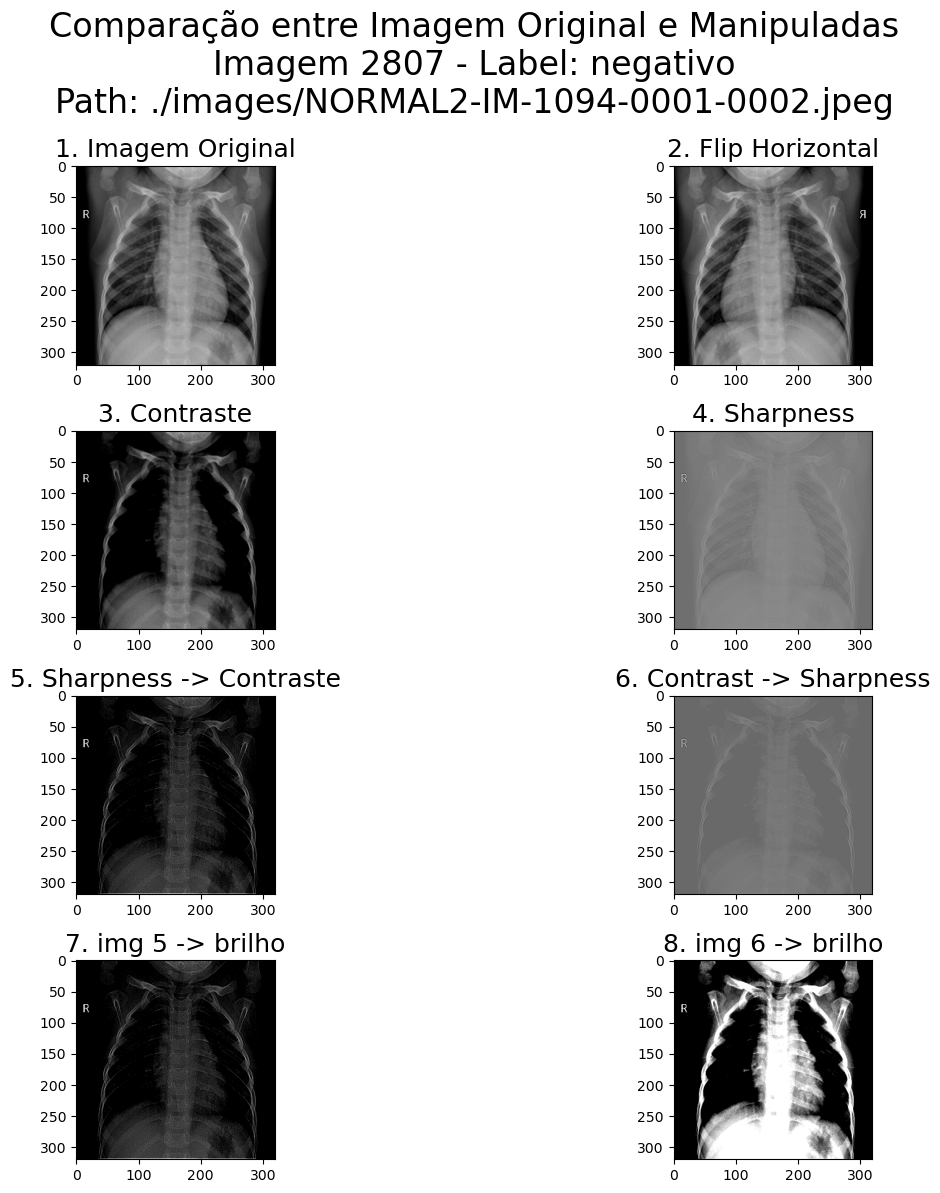

In [53]:
# Escolhe imagem aleatória no conjunto de treino
idx_aleatorio = random.randint(0, train_pneumonia.shape[0]-1)

original = carrega_imagem(train_pneumonia['path'][idx_aleatorio], DIM_IMAGEM)

fig, axs = plt.subplots(4, 2, figsize=(15, 12))
axs[0, 0].set_title('1. Imagem Original', fontsize = 18)
axs[0, 0].imshow(original, cmap='gray')

axs[0, 1].set_title('2. Flip Horizontal', fontsize = 18)
flipada = flip_horizontal(original)
axs[0, 1].imshow(flipada, cmap='gray')

axs[1, 0].set_title('3. Contraste', fontsize = 18)
contraste1 = aumentar_contraste(original, 50)
axs[1, 0].imshow(contraste1, cmap='gray')

axs[1, 1].set_title('4. Sharpness', fontsize = 18)
sharpness1 = aumentar_sharpness(original, 5)
axs[1, 1].imshow(sharpness1, cmap='gray')

axs[2, 0].set_title('5. Sharpness -> Contraste', fontsize = 18)
contraste2 = aumentar_contraste(aumentar_sharpness(original, 5), 50)
axs[2, 0].imshow(contraste2, cmap='gray')

axs[2, 1].set_title('6. Contrast -> Sharpness', fontsize = 18)
sharpness2 = aumentar_sharpness(aumentar_contraste(original, 50), 5)
axs[2, 1].imshow(sharpness2, cmap='gray')

axs[3, 0].set_title('7. img 5 -> brilho', fontsize = 18)
brilho1 = aumentar_brilho(aumentar_contraste(aumentar_sharpness(original, 5), 50), 0.5)
axs[3, 0].imshow(brilho1, cmap='gray')

axs[3, 1].set_title('8. img 6 -> brilho', fontsize = 18)
brilho2 = aumentar_brilho(aumentar_sharpness(aumentar_contraste(original, 5), 50), 0.5)
axs[3, 1].imshow(brilho2, cmap='gray')

rotulo = train_pneumonia['Label'][idx_aleatorio]
path = train_pneumonia['path'][idx_aleatorio]
plt.suptitle(f'Comparação entre Imagem Original e Manipuladas\nImagem {idx_aleatorio} - Label: {rotulo}\nPath: {path}', 
             y = 0.99, fontsize = 24)

plt.tight_layout()
plt.show()

Observando os testes acima, percebemos que aplicar contraste, sharpness e em seguida brilho traz uma melhoria visual significativa nas informações da imagem, trazendo detalhes nas áreas claras e cinzas e recuperando informações nas áreas escuras.

A seguir faremos o processo de data augmentation para melhorar o balanceamento das classes no conjunto de treino e então aplicar essa sequência de processamento em todo dataset.

### Função de Pré-Processamento

In [54]:
# Função para melhorar a imagem (pré-processamento)
def melhora_imagem(imagem):
    imagem_processada = aumentar_brilho(aumentar_sharpness(aumentar_contraste(imagem, 5), 50), 0.5)
    return imagem_processada

### Data Augmentation na classe `negativo` para treino e teste.

Vamos trabalhar a classe `negativo` em ambos conjuntos de treino e teste de maneira que ambos tenham proporção aproximada/similar.

In [55]:
train_pneumonia['Label'].value_counts()

positivo    3099
negativo    1038
Name: Label, dtype: int64

In [56]:
train_pneumonia['Label'].value_counts(normalize = True)

positivo    0.749094
negativo    0.250906
Name: Label, dtype: float64

In [57]:
train_negativo = train_pneumonia[train_pneumonia['Label'] == 'negativo']
train_negativo_aumentadas = []

Para o Raio X iremos fazer apenas o flip horizontal, pois entendemos que alterar proporções ou fazer giros podem alterar características importantes da imagem e que podem atrapalhar o desempenho do modelo.

In [58]:
# Função para carregar e flipar horizontalmente a imagem para treino
def carrega_e_flipa_train(path):
    imagem = carrega_imagem(path, DIM_IMAGEM)
    train_negativo_aumentadas.append(flip_horizontal(imagem))

In [59]:
train_negativo['path'].apply(carrega_e_flipa_train)

4       None
5       None
11      None
15      None
17      None
        ... 
4118    None
4123    None
4126    None
4133    None
4135    None
Name: path, Length: 1038, dtype: object

In [60]:
len(train_negativo_aumentadas)

1038

In [61]:
target_train_negativo_aumentadas = np.zeros(len(train_negativo_aumentadas))

In [62]:
target_train_negativo_aumentadas

array([0., 0., 0., ..., 0., 0., 0.])

Transformamos o conjunto de treino em um array de imagens

In [63]:
train_pneumonia_array = []
train_pneumonia['path'].apply(lambda i: train_pneumonia_array.append(carrega_imagem(i, DIM_IMAGEM)))

0       None
1       None
2       None
3       None
4       None
        ... 
4132    None
4133    None
4134    None
4135    None
4136    None
Name: path, Length: 4137, dtype: object

In [64]:
len(train_pneumonia_array)

4137

Concatenamos ao conjunto de treino original as imagens que geramos (data augmentation) e o array de labels respectivamente em `X_train` e `y_train`.

In [65]:
X_train = np.concatenate((np.array(train_pneumonia_array), np.array(train_negativo_aumentadas)))
y_train = np.int64(np.concatenate((np.array(train_pneumonia['target'].values), np.array(target_train_negativo_aumentadas))))

In [66]:
X_train.shape

(5175, 320, 320, 1)

In [67]:
y_train.shape

(5175,)

Verificamos a proporção final. Esta será a proporção que iremos procurar obter no conjunto de teste.

In [68]:
display(pd.DataFrame(y_train).value_counts())
display(pd.DataFrame(y_train).value_counts(normalize = True) * 100)

1    3099
0    2076
dtype: int64

1    59.884058
0    40.115942
dtype: float64

Aproximadamente 60% para classe `positivo` e 40% para classe `negativo`.

Precisamos de $ 40 \times 1235 \div 60 \approx 827$ amostras a mais na classe `negativo` para termos proporção similar ao conjunto de treino.

In [69]:
# Função para carregar e flipar horizontalmente a imagem para teste
def carrega_e_flipa_test(path):
    imagem = carrega_imagem(path, DIM_IMAGEM)
    test_negativo_aumentadas.append(flip_horizontal(imagem))

In [70]:
test_pneumonia_array = []
test_pneumonia['path'].apply(lambda i: test_pneumonia_array.append(carrega_imagem(i, DIM_IMAGEM)))

0       None
1       None
2       None
3       None
4       None
        ... 
1768    None
1769    None
1770    None
1771    None
1772    None
Name: path, Length: 1773, dtype: object

In [71]:
test_negativo = test_pneumonia[test_pneumonia['Label'] == 'negativo']

qtd_test_negativo_aumentadas = 827 - 538

test_negativo_aumentadas = []

In [72]:
test_negativo.sample(n = qtd_test_negativo_aumentadas)['path'].apply(carrega_e_flipa_test)

829     None
609     None
1010    None
7       None
1750    None
        ... 
1555    None
278     None
902     None
867     None
8       None
Name: path, Length: 289, dtype: object

In [73]:
len(test_negativo_aumentadas)

289

In [74]:
len(test_pneumonia_array)

1773

In [75]:
target_test_negativo_aumentadas = np.zeros(len(test_negativo_aumentadas))

In [76]:
target_test_negativo_aumentadas

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Concatenamos ao conjunto de teste original as imagens que geramos (data augmentation) e o array de labels respectivamente em `X_test` e `y_test`.

In [77]:
X_test = np.concatenate((np.array(test_pneumonia_array), np.array(test_negativo_aumentadas)))
y_test = np.int64(np.concatenate((np.array(test_pneumonia['target'].values), np.array(target_test_negativo_aumentadas))))

In [78]:
X_test.shape

(2062, 320, 320, 1)

In [79]:
y_test.shape

(2062,)

Com o X_train contendo todas as imagens de treino, vamos passar a função de processamento de imagens nela.

In [80]:
X_train = np.array([melhora_imagem(imagem) for imagem in np.array(X_train)])

Como fizemos data augmentation, embaralhamos o dataframe para não gerar nenhum viés

In [81]:
# Combinar, embaralhar, descombinar os dados de treino

treino_temp = list(zip(X_train, y_train))

np.random.shuffle(treino_temp)

X_train, y_train = zip(*treino_temp)

X_train = np.array(X_train)
y_train = np.array(y_train)

Fazemos a mesma coisa para o conjunto de testes.

In [82]:
X_test = np.array([melhora_imagem(imagem) for imagem in np.array(X_test)])

In [83]:
# Combinar, embaralhar, descombinar os dados de treino

test_temp = list(zip(X_test, y_test))

np.random.shuffle(test_temp)

X_test, y_test = zip(*test_temp)

X_test = np.array(X_test)
y_test = np.array(y_test)

Verificamos uma imagem do conjunto de treino e outra do conjunto de testes.

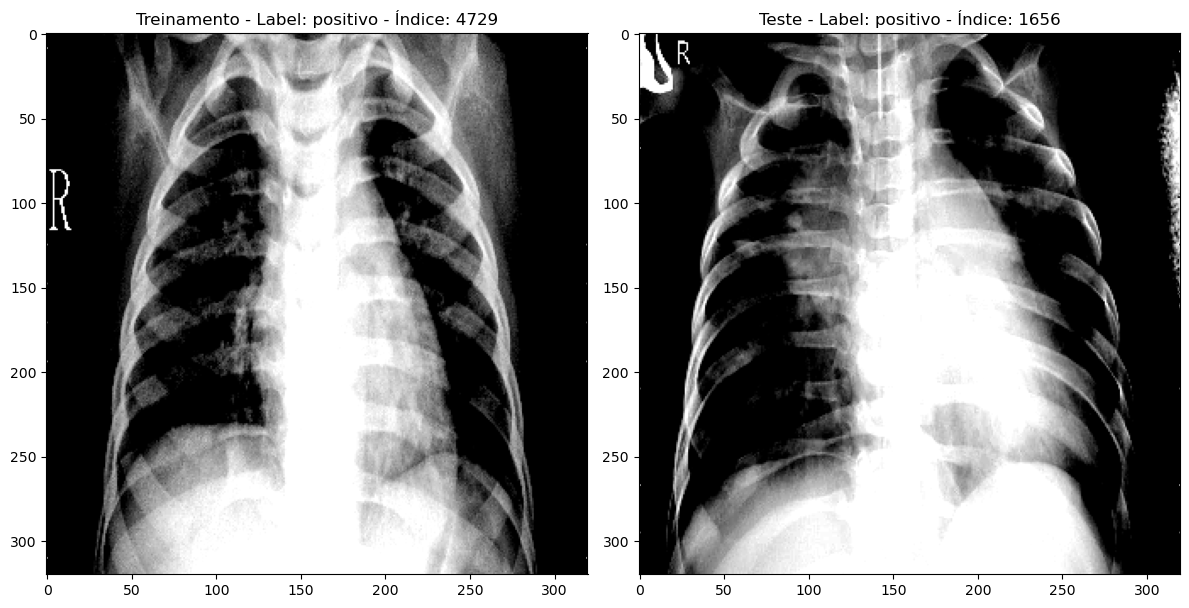

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

img_aleatoria_treinamento = random.randint(0, len(X_train) - 1)
label_treinamento = "negativo" if y_train[img_aleatoria_treinamento] == 0 else "positivo"
imagem_treinamento = X_train[img_aleatoria_treinamento]

img_aleatoria_teste = random.randint(0, len(X_test) - 1)
label_teste = "negativo" if y_test[img_aleatoria_teste] == 0 else "positivo"
imagem_teste = X_test[img_aleatoria_teste]

axes[0].imshow(imagem_treinamento, cmap='gray')
axes[0].set_title(f'Treinamento - Label: {label_treinamento} - Índice: {img_aleatoria_treinamento}')

axes[1].imshow(imagem_teste, cmap='gray')
axes[1].set_title(f'Teste - Label: {label_teste} - Índice: {img_aleatoria_teste}')

plt.tight_layout()
plt.show()

## Criação do modelo a partir da LetNet-5

Iniciamos os estudos a partir do modelo LetNet-5 e fomos modificando a medida que testávamos e avaliávamos o desempenho a partir das métricas como Matriz de Confusão, Curva Roc e Matriz de Classificação.

A arquitetura da rede aqui apresentada é o resultado deste estudo.

In [85]:
# Inicialização
model = Sequential()

model.add(Conv2D(8, (4, 4), activation = 'sigmoid', input_shape = (DIM_IMAGEM[0], DIM_IMAGEM[1], 1)))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.1))

model.add(Conv2D(8, (4, 4), activation = 'sigmoid'))
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(8, (4, 4), activation = 'sigmoid'))
model.add(AveragePooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(8, (4, 4), activation = 'sigmoid'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation = 'sigmoid'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

Tanto a função **sigmoid** como a função **ReLU** são funções não lineares. A escolha da função **sigmoid** nas camadas de confolução e na primeira camada densa se deu para ajudar o modelo a aprender representações mais sutis dos dados, uma vez que as imagens podem conter diferenças muito pouco perceptíveis entre um pulmão saudável e um com pneumonia. A flexibilidade da função **sigmoid** foi fundamental. Durante os estudos, as tentativas de utilizar **ReLU** nessas camadas resultaram numa significativa piora do modelo, mesmo assim, ao colocar a **ReLU** nas duas camadas densas de 128 e 64 neurônios evitou o modelo de atingir o overfit, que aconteceu diversas vezes quando usando também **sigmoid** nessas camadas.

Também, a escolha da função **sigmoid** na camada de saída foi por conta de se tratar de uma tarefa de classificação binária. A função mapeia a saída para uma probabilidade, entre 0 e 1.

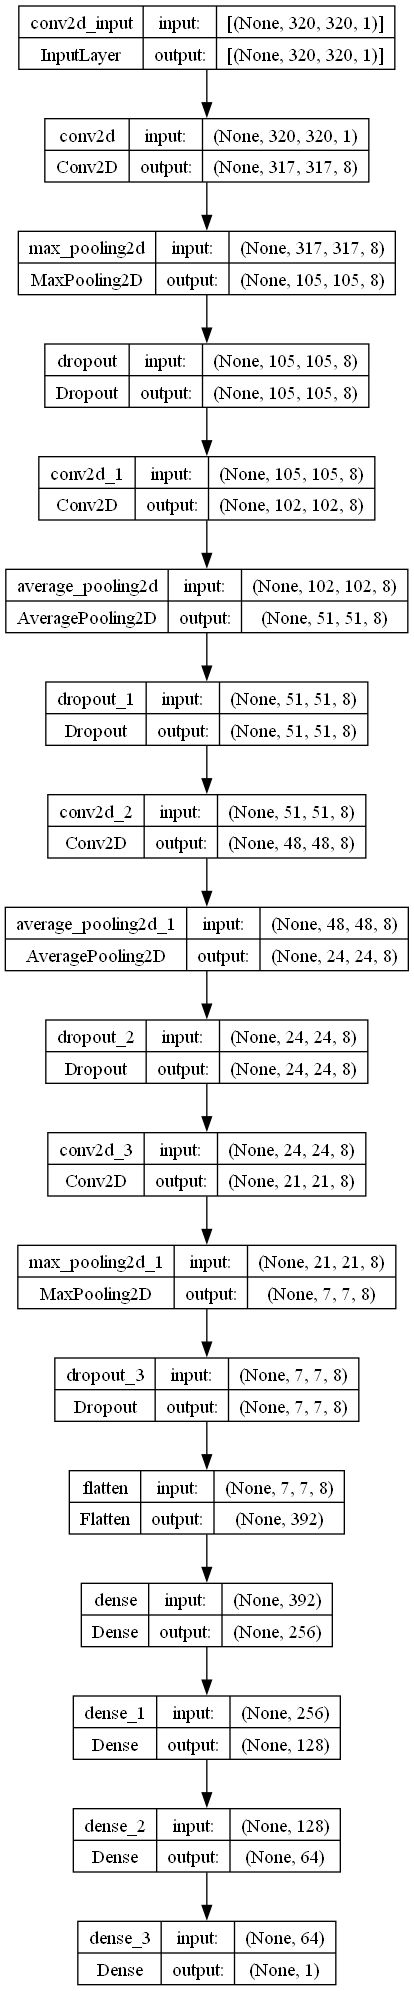

In [86]:
plot_model(model, to_file='CoronaHack.png', show_shapes=True)

In [87]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 317, 317, 8)       136       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 105, 105, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 105, 105, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 102, 8)       1032      
                                                                 
 average_pooling2d (AverageP  (None, 51, 51, 8)        0         
 ooling2D)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 51, 51, 8)         0

In [88]:
taxa_aprendizado = 0.001
optimizer = Adam(learning_rate = taxa_aprendizado)

A taxa de aprendizado de 0.001 foi utilizada. Testamos diversos valores acima e abaixo disso, encontrando situações de overfit ou de desempenho ruim. 0.001 foi uma taxa baixa o suficiente para evitar o overfitting e alta o suficiente para que o modelo pudesse detectar e aprender os padrões existentes nos dados.

In [89]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [90]:
checkpoint = ModelCheckpoint('modelo_bao.h5', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

In [91]:
treinamento = model.fit(X_train,  y_train, validation_split = 0.30, epochs = 30, batch_size = 4, callbacks = [checkpoint])

Epoch 1/30
906/906 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6541
Epoch 1: val_loss improved from inf to 0.26920, saving model to modelo_bao.h5
906/906 [==============================] - 52s 56ms/step - loss: 0.6029 - accuracy: 0.6541 - val_loss: 0.2692 - val_accuracy: 0.8841
Epoch 2/30
906/906 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9014
Epoch 2: val_loss improved from 0.26920 to 0.20120, saving model to modelo_bao.h5
906/906 [==============================] - 49s 54ms/step - loss: 0.2329 - accuracy: 0.9014 - val_loss: 0.2012 - val_accuracy: 0.9137
Epoch 3/30
905/906 [============================>.] - ETA: 0s - loss: 0.2017 - accuracy: 0.9163
Epoch 3: val_loss did not improve from 0.20120
906/906 [==============================] - 49s 54ms/step - loss: 0.2016 - accuracy: 0.9163 - val_loss: 0.2115 - val_accuracy: 0.9137
Epoch 4/30
906/906 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9296
Epoch 4: v

905/906 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9815
Epoch 29: val_loss did not improve from 0.13292
906/906 [==============================] - 50s 56ms/step - loss: 0.0463 - accuracy: 0.9815 - val_loss: 0.1779 - val_accuracy: 0.9478
Epoch 30/30
905/906 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9870
Epoch 30: val_loss did not improve from 0.13292
906/906 [==============================] - 49s 54ms/step - loss: 0.0388 - accuracy: 0.9870 - val_loss: 0.1838 - val_accuracy: 0.9427


Algumas observações sobre os hiperparâmetros e escolhas acima. 

O otimizador escolhido, Adam, é um algoritmo de gradiente descendente estocástico que é geralmente considerado uma boa escolha para tarefas de Deep Learning.

Escolhemos lote de 4, pequeno, para ajudar a evitar o overfitting. Durante os estudos, lotes maiores apresentaram overfitting ou algo próximo à isso, e nestas ocasiões, o desempenho com os dados de treinamento era ótimo e ruim com o de validação, coisa que se mostrava ainda pior com os dados de teste.

Começamos com um número de épocas bem alto (200) e fomos observando os comportamentos. Percebemos que o melhor modelo nunca era encontrado depois de 30 épocas. Também preferimos usar ModelCheckpoint e observar a perda no modelo com os dados de validação uma vez que estes não são usados para o treinamento e então é um parâmetro que não vai ter viés.

Abaixo mostramos as métricas do modelo.

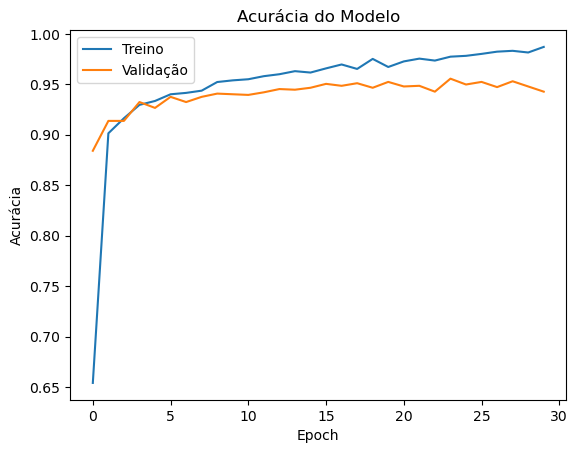

In [92]:
plt.figure(1)
plt.plot(treinamento.history['accuracy'])
plt.plot(treinamento.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Epoch')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

In [93]:
modelo_otimo = load_model('modelo_bao.h5' )

In [94]:
predictions = modelo_otimo.predict(X_test)

65/65 [==============================] - 5s 76ms/step


In [95]:
y_pred = (predictions > 0.5).astype(int)

In [96]:
cm = confusion_matrix(y_test, y_pred)

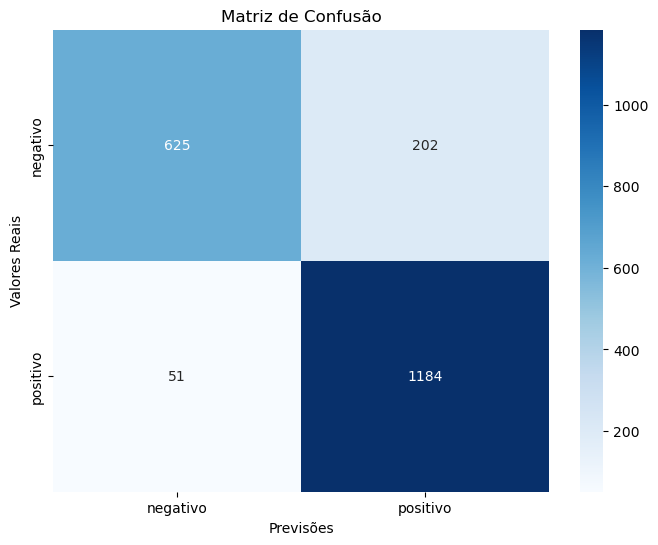

In [97]:
# Plota a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negativo", "positivo"], yticklabels=["negativo", "positivo"])
plt.xlabel("Previsões")
plt.ylabel("Valores Reais")
plt.title("Matriz de Confusão")
plt.show()

In [98]:
# Relatório de classificação
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       827
           1       0.85      0.96      0.90      1235

    accuracy                           0.88      2062
   macro avg       0.89      0.86      0.87      2062
weighted avg       0.88      0.88      0.87      2062



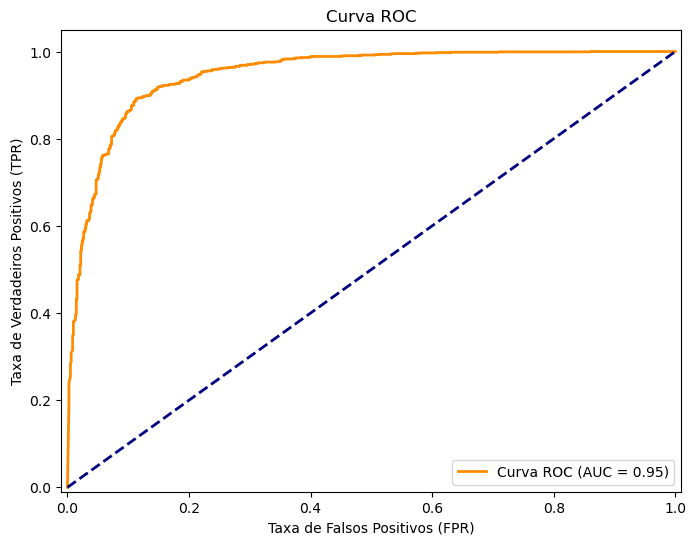

In [99]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Área sob a curva ROC (AUC)
roc_auc = roc_auc_score(y_test, predictions)

# Plote a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


A escolha dos hiperparâmetros foi bem-sucedida, pois o modelo obteve um bom desempenho na tarefa de identificação de pacientes com pneumonia. O AUC de 0,95 indica que o modelo é muito bom em distinguir entre pacientes com pneumonia e pacientes sem pneumonia.

## Conclusão

No presente trabalho, desenvolvemos um modelo de análise de imagens de Raio-X com propósito de identificar pacientes com pneumonia. O modelo foi treinado a partir de um conjunto de 5910 imagens de raio-x de pacientes com e sem pneumonia. 

Fizemos análise exploratória dos dados e das imagens e posteriormente um pré-processamento afim de evidenciar os padrões ocultos que elas poderiam conter.

Lançamos mão de técnicas de _data augmentation_ para aumentar a classe minoritária, no caso os Raio-X de pulmões saudáveis (negativo), utilizando apenas flip horizontal. O balanceamento foi feito tanto no conjunto de treino como de teste.

Como visto acima, o modelo teve um AUC de 0,95, o que indica que ele é muito bom em distinguir entre pacientes com pneumonia e pacientes sem pneumonia. O modelo também teve uma alta taxa de verdadeiros positivos e uma baixa taxa de falsos positivos.